**HOUGH ALGORITAM ZA DETEKCIJU TABLE**

U ovom fajlu implementiran je kompletan pipeline za detekciju šahovske table koristeći Hough transformaciju i evaluaciju rezultata na osnovu COCO ground-truth anotacija. Najpre se učitavaju sve slike iz dataset-a i definišu pomoćne funkcije za prikaz i crtanje rezultata. Zatim se detekcija table radi tako što se slika preprocesira (grayscale + blur), binarizuje adaptivnim threshold-om, nakon čega se pomoću HoughLinesP detektuju linijski segmenti. Detektovane linije se klasifikuju na horizontalne i vertikalne prema uglu, a zatim se biraju “spoljašnje” linije (gornja, donja, leva i desna) na osnovu njihovog položaja (rho). Presecima tih linija dobijaju se četiri ugla table, koji se uređuju u standardni redosled i validiraju po veličini/površini.

Nakon detekcije, fajl učitava COCO anotacije i za svaku sliku pronalazi odgovarajući GT objekat (tabla). Predikcija i GT se pretvaraju u binarne maske i računa se IoU po slici, uz izračunavanje zbirnih metrika (mean/median/min/max) i listanje najboljih/najgorih slučajeva.
Na kraju se radi analiza grešaka: za najlošije primere vizuelno se prikazuju GT i predikcija kao overlay, kao i razlika (promašaj i višak), a rezultati se čuvaju u CSV radi kasnijeg poređenja različitih metoda i parametara.

Broj slika: 329
Primeri: ['/content/soft-canny/00bc0cacffdebe6b11bdeec56f63ee49_jpg.rf.UeIalh1bhfXlMPNMd9qy.jpg', '/content/soft-canny/0115e4df73475b550e5c6f7a88b2474f_jpg.rf.MGZokKOBcnlIjJhSCpJy.jpg', '/content/soft-canny/02f0931b536dfba10affc3231a3d64fb_jpg.rf.TgCy7CjpH8A0dUYPHOxd.jpg', '/content/soft-canny/0301b7f9ed4d5ba503fda79fc4370c29_jpg.rf.F3nEFKMliFZXsjGVWSFL.jpg', '/content/soft-canny/03886821377011fec599e8fa12d86e89_jpg.rf.zQhDHVTwrax80bl2kdsc.jpg']


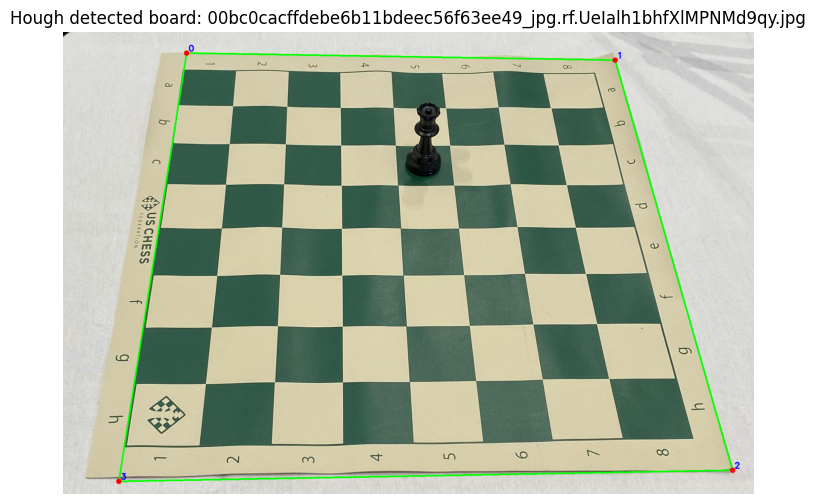

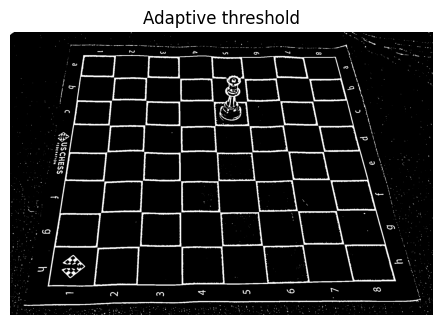

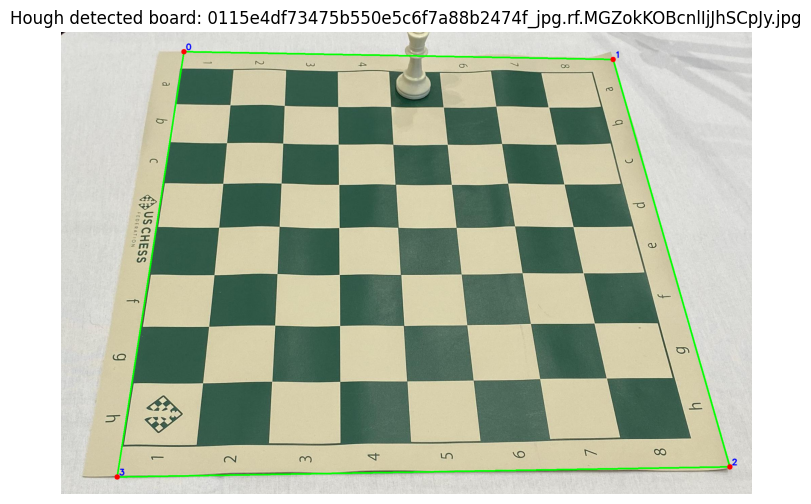

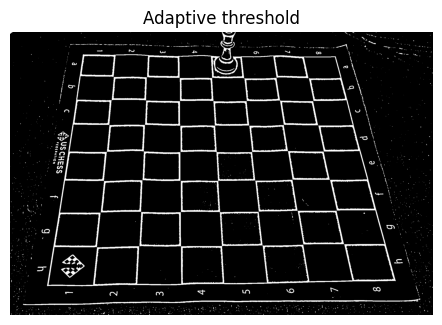

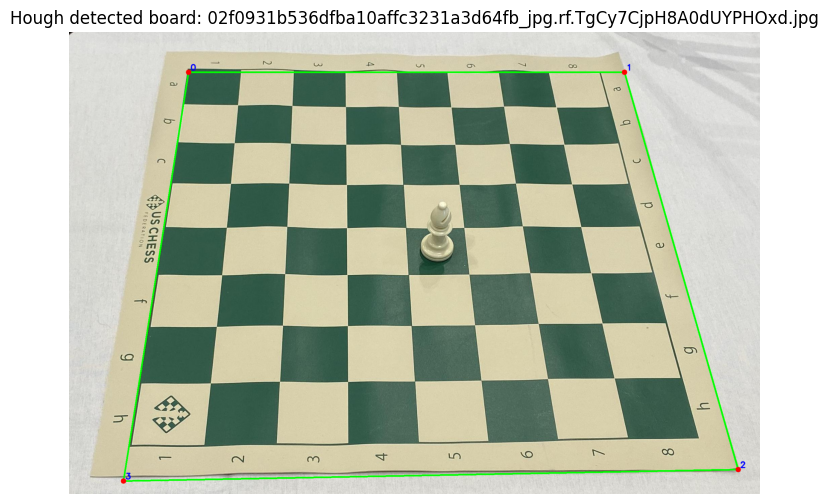

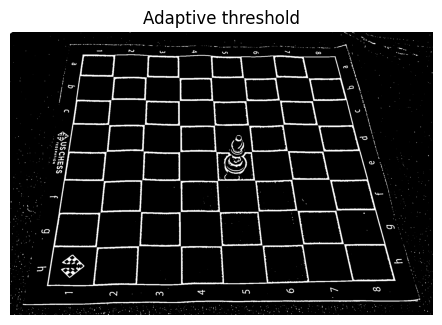

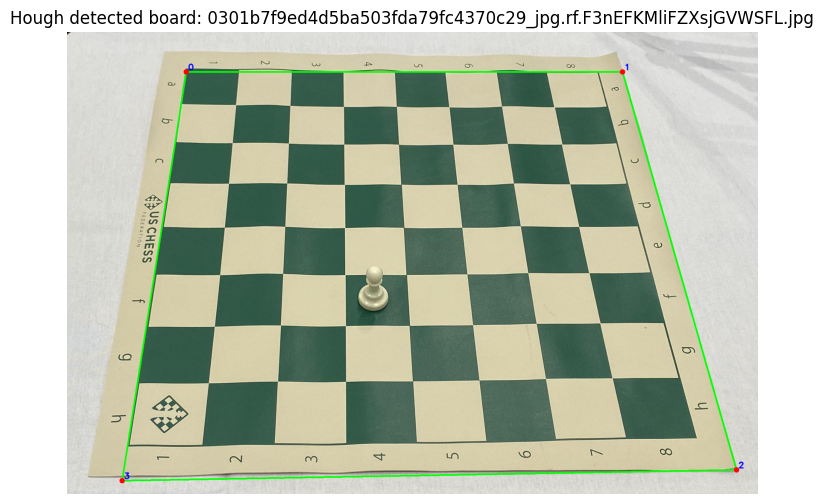

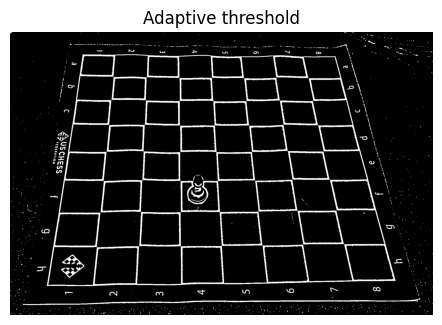

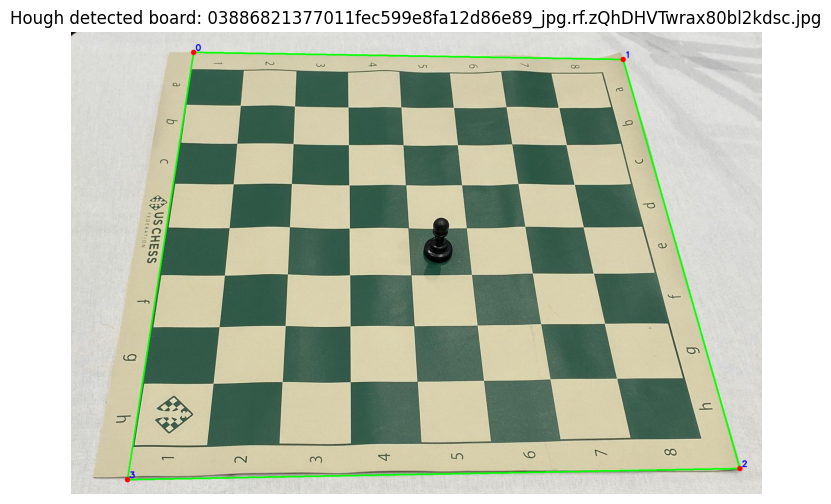

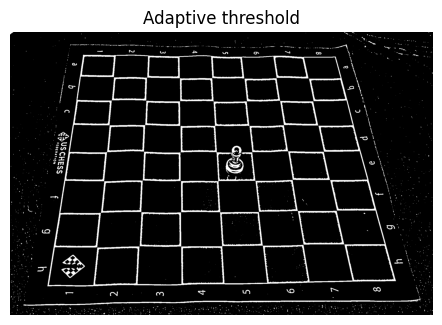

Ukupno vreme za sve slike: 126.652 s
Prosečno po slici: 384.96 ms
Ukupno slika: 329
Valid IoU slika: 329
Mean IoU: 0.7834623830965167
Median IoU: 0.8445517475704738
Predikcija uspešna (quad != None): 0.9726443768996961

Najgore (IoU):


file  iou  has_pred
223           IMG_4054_jpg.rf.aoyozh3Urc15bQwhQ8Ox.jpg  0.0     False
232           IMG_4067_jpg.rf.QPp04jPFMS7rnQagj06S.jpg  0.0     False
227           IMG_4060_jpg.rf.A1XWDz26H0XBrAe5KhmO.jpg  0.0     False
226           IMG_4059_jpg.rf.zawmVoYmQQDsMDrJXzol.jpg  0.0     False
233           IMG_4068_jpg.rf.nGa5k5AZ7BLh0GbmIcma.jpg  0.0     False
252  b7a8c7de4fe1382d69f58ac97e819b5c_jpg.rf.i8vNtJ...  0.0     False
206           IMG_4009_jpg.rf.7X6vVZhSq4yfxVYD8s3I.jpg  0.0     False
210           IMG_4016_jpg.rf.yx3wO7fVScTvhmRXBF1G.jpg  0.0     False
196           IMG_3992_jpg.rf.HQGTxfuqUQe3WygZai2c.jpg  0.0     False
208           IMG_4013_jpg.rf.s0QRC0feeVJeg59ohFTe.jpg  0.0      True


Najbolje (IoU):


file       iou  has_pred
126  6f0a888f9e5aed9516e336fd04723ce1_jpg.rf.Rvvwhn...  0.876412      True
52   3161933dffedf8a859d6623a99492c53_jpg.rf.sc9yly...  0.873269      True
324  fa4e2b9a8cf58f405f69a56c662834f2_jpg.rf.e7x65V...  0.872770      True
190       IMG_0317_JPG_jpg.rf.vyTjJcCZPVekunqEnWTX.jpg  0.872006      True
267  c76c79e40bd9839a05237934cfa89ca3_jpg.rf.YlBB4m...  0.871454      True
62   383c2ed7bbe2d327ab55a871db497c33_jpg.rf.FEsb6X...  0.871405      True
65   3914be0cea4aa8a6bbd1081ec3b034a7_jpg.rf.sLWK55...  0.871101      True
51   31419854b103ca6becc4cc394c449e95_jpg.rf.MoYhIS...  0.870896      True
122  6a41b6c8201604216ad196f842c6a2c6_jpg.rf.lONE5q...  0.870520      True
138  7df16cd59fb40e0691948cc805e4801b_jpg.rf.YGjW2J...  0.869838      True

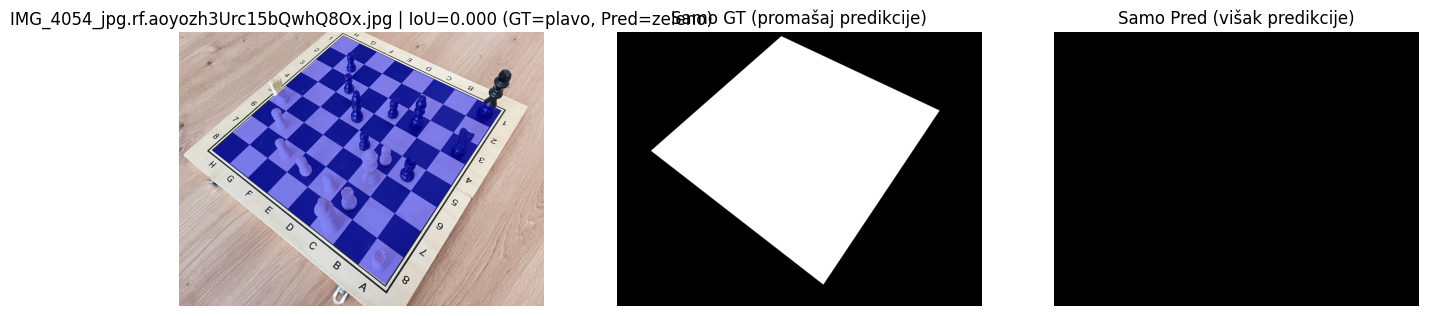

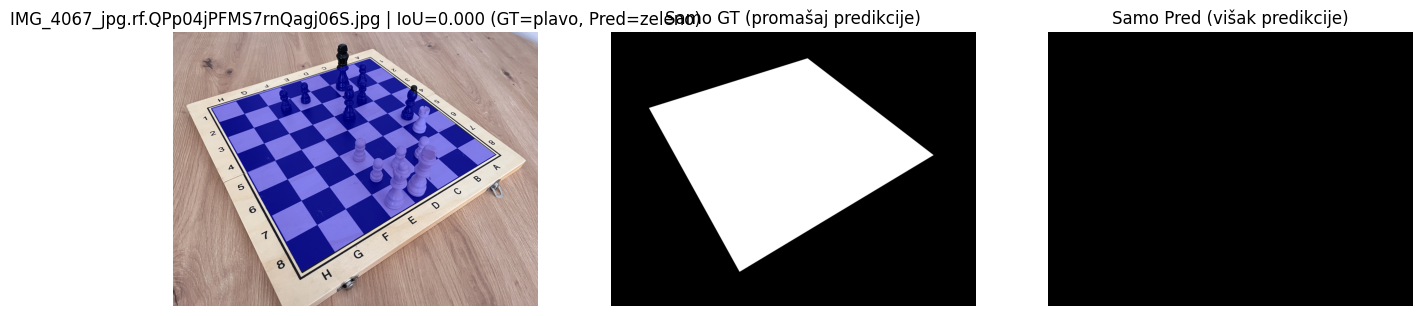

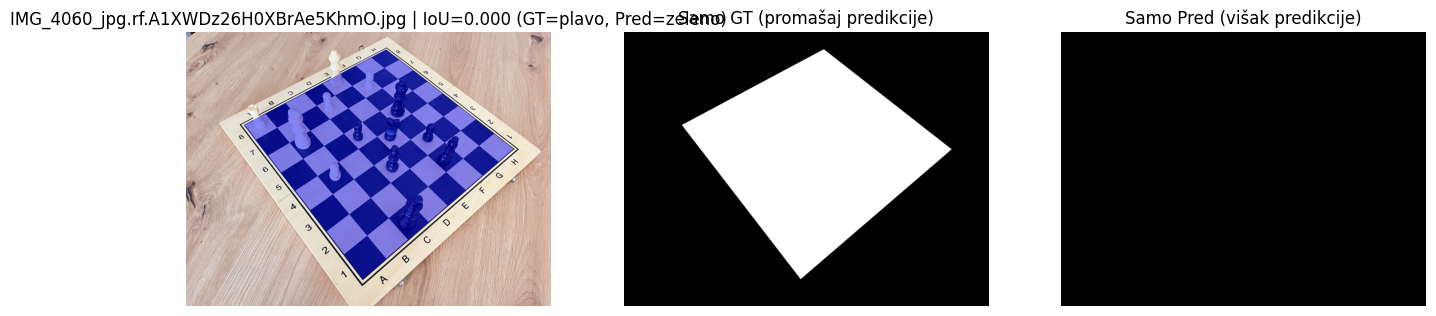

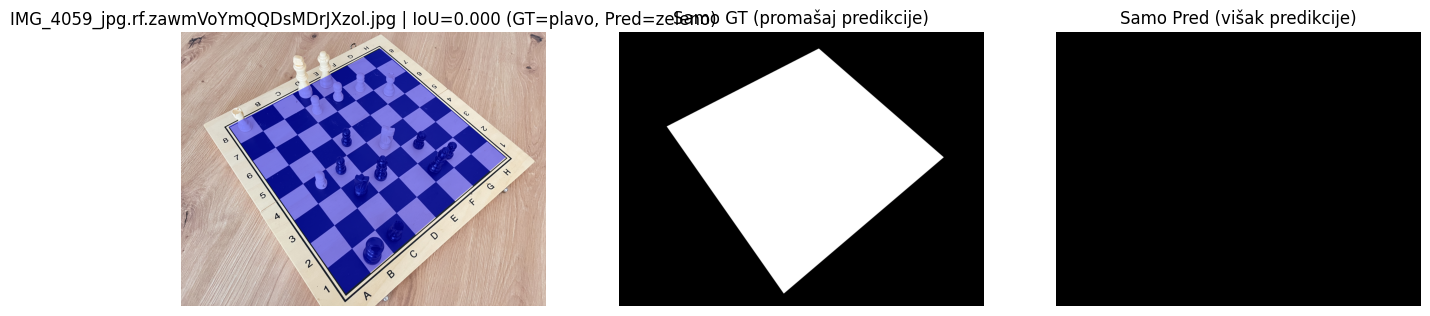

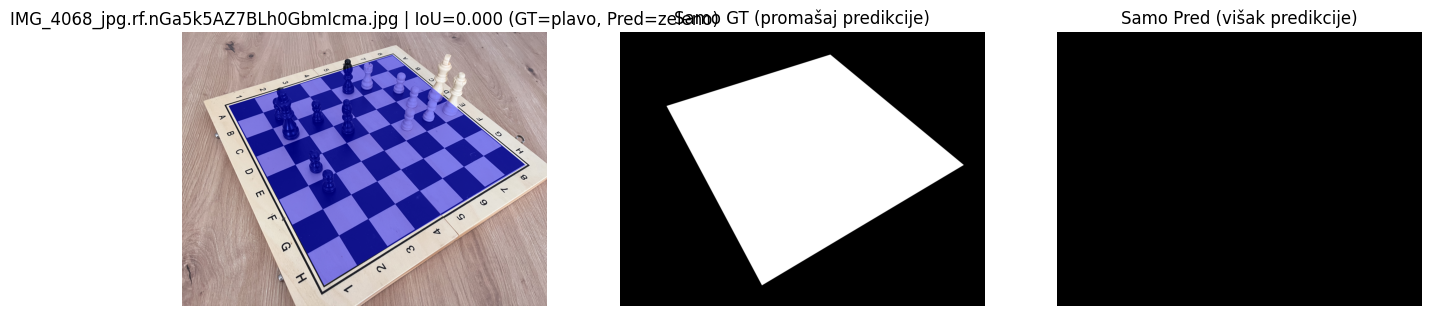


--- IoU SUMMARY (ceo dataset) ---
Broj slika sa GT: 329
Mean IoU: 0.7834623830965167
Median IoU: 0.8445517475704738
Min IoU: 0.0
Max IoU: 0.8764123706182319
Pct IoU >= 0.99: 0.000
Pct IoU >= 0.95: 0.000
Pct IoU >= 0.90: 0.000
Pct IoU >= 0.85: 0.407
Pct IoU >= 0.80: 0.827
Saved: /content/iou_results_hough.csv


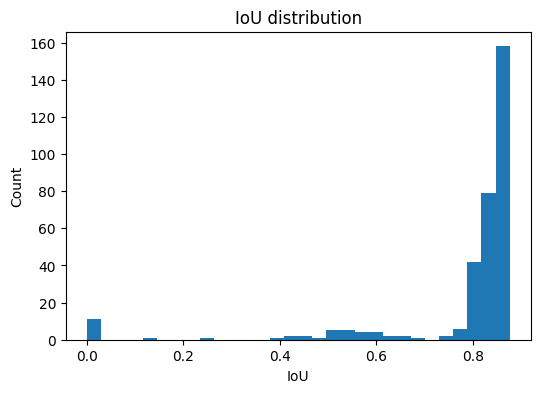

In [3]:
!pip -q install opencv-python-headless matplotlib

import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import time

DATA_DIR = "/content/soft-canny"
IMG_GLOBS = ["*.jpg", "*.jpeg", "*.png", "*.webp"]

# Učitava i vraća sortiranu listu putanja svih slika iz foldera
def list_images(data_dir):
    paths = []
    for g in IMG_GLOBS:
        paths.extend(glob.glob(os.path.join(data_dir, g)))
    return sorted(paths)

# Prikazuje BGR sliku (OpenCV) u Matplotlib-u tako što je prvo konvertuje u RGB.
def show_bgr(img_bgr, title="", figsize=(10,6)):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=figsize)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

#Sortira 4 temena četvorougla u fiksni redosled: TL, TR, BR, BL
def order_points(pts):
    pts = np.array(pts, dtype=np.float32)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1).reshape(-1)
    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]
    return np.array([tl, tr, br, bl], dtype=np.float32)

# Crta pronađeni četvorougao preko slike
def draw_quad(img_bgr, quad, color=(0,255,0), thickness=3):
    out = img_bgr.copy()
    if quad is None:
        return out
    pts = quad.astype(np.int32).reshape(-1,1,2)
    cv2.polylines(out, [pts], isClosed=True, color=color, thickness=thickness)
    for i, (x,y) in enumerate(quad.astype(int)):
        cv2.circle(out, (x,y), 8, (0,0,255), -1)
        cv2.putText(out, str(i), (x+6,y-6), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2, cv2.LINE_AA)
    return out


# HOUGH helpers

#Pretvara linijski segment iz Hough-a u normalizovanu jednačinu prave a·x + b·y + c = 0 i računa (rho).
#Tako da se linije mogu pouzdano porediti i sortirati (npr. najgornja/najdonja, najleva/najdesnija).
def line_from_segment(x1, y1, x2, y2):
    a = float(y2 - y1)
    b = float(x1 - x2)
    c = -(a * x1 + b * y1)
    norm = np.hypot(a, b)
    if norm < 1e-8:
        return None

    a /= norm; b /= norm; c /= norm


    if abs(a) > abs(b):
        if a < 0:
            a, b, c = -a, -b, -c
    else:
        if b < 0:
            a, b, c = -a, -b, -c

    rho = -c  # kad je normalizovano
    return (a, b, c, rho)

#Računa tačku preseka dve prave zadate koeficijentima (a, b, c);
#koristi se da se iz preseka izabranih spoljašnjih linija dobiju uglovi table
def intersect_lines(L1, L2):

    a1, b1, c1 = L1
    a2, b2, c2 = L2
    d = a1*b2 - a2*b1
    if abs(d) < 1e-8:
        return None
    x = (b1*c2 - b2*c1) / d
    y = (c1*a2 - c2*a1) / d
    return np.array([x, y], dtype=np.float32)

# Core: THRESH -> HOUGH -> 4 spoljne linije -> 4 ugla
#Glavna detekcija table zasnovana na linijama:
#grayscale + blur
#adaptive threshold (binarizacija)
#HoughLinesP detekcija segmenata
#klasifikacija segmenata na horizontalne i vertikalne po uglu
#izbor spoljašnjih linija (top/bottom i left/right) po rho
#preseci linija → 4 ugla table → quad
#validacija (da je unutar slike i da ima dovoljnu površinu)
def detect_chessboard_quad_hough(
    img_bgr,
    blur_ksize=5,
    adapt_block=31,
    adapt_C=7,
    morph_ksize=7,
    morph_iter=2,
    hough_rho=1,
    hough_theta=np.pi/180,
    hough_thresh=120,
    min_line_length_ratio=0.20,  # deo min(h,w)
    max_line_gap=20,
    angle_tol_deg=20,            # tolerancija za klasifikaciju linija
    min_area_ratio=0.08
):
    h, w = img_bgr.shape[:2]
    img_area = h * w
    min_area = min_area_ratio * img_area

    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)


    thr = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        adapt_block, adapt_C
    )

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (morph_ksize, morph_ksize))

    minLineLength = int(min(h, w) * min_line_length_ratio)
    lines = cv2.HoughLinesP(
        thr,
        rho=hough_rho,
        theta=hough_theta,
        threshold=hough_thresh,
        minLineLength=minLineLength,
        maxLineGap=max_line_gap
    )

    debug = {
        "gray": gray,
        "thr": thr,
       # "proc": proc,
        "raw_lines": lines
    }

    if lines is None or len(lines) < 10:
        return None, debug

    angle_tol = np.deg2rad(angle_tol_deg)

    horizontals = []
    verticals = []

    for l in lines.reshape(-1, 4):
        x1, y1, x2, y2 = map(int, l)
        dx = x2 - x1
        dy = y2 - y1
        if dx == 0 and dy == 0:
            continue
        theta = np.arctan2(dy, dx)  # -pi..pi
        abs_theta = abs(theta)

        # horizontalno: blizu 0 ili pi
        if abs_theta < angle_tol or abs(abs_theta - np.pi) < angle_tol:
            L = line_from_segment(x1, y1, x2, y2)
            if L: horizontals.append(L)
        # vertikalno: blizu pi/2
        elif abs(abs_theta - np.pi/2) < angle_tol:
            L = line_from_segment(x1, y1, x2, y2)
            if L: verticals.append(L)

    debug["horiz_count"] = len(horizontals)
    debug["vert_count"] = len(verticals)

    if len(horizontals) < 2 or len(verticals) < 2:
        return None, debug

    # Uzima spoljašnje linije po rho (min/max)
    horizontals_sorted = sorted(horizontals, key=lambda t: t[3])  # rho
    verticals_sorted   = sorted(verticals,   key=lambda t: t[3])

    top    = horizontals_sorted[0]
    bottom = horizontals_sorted[-1]
    left   = verticals_sorted[0]
    right  = verticals_sorted[-1]

    # presek (a,b,c) delova
    topL    = intersect_lines(top[:3], left[:3])
    topR    = intersect_lines(top[:3], right[:3])
    bottomR = intersect_lines(bottom[:3], right[:3])
    bottomL = intersect_lines(bottom[:3], left[:3])

    if any(p is None for p in [topL, topR, bottomR, bottomL]):
        return None, debug

    quad = order_points([topL, topR, bottomR, bottomL])

    # Validacija: da je unutar slike + da je dovoljno veliko
    quad_clipped = quad.copy()
    quad_clipped[:, 0] = np.clip(quad_clipped[:, 0], 0, w-1)
    quad_clipped[:, 1] = np.clip(quad_clipped[:, 1], 0, h-1)

    area = cv2.contourArea(quad_clipped.reshape(-1,1,2).astype(np.float32))
    if area < min_area:
        return None, debug

    debug["chosen_lines"] = {
        "top": top, "bottom": bottom, "left": left, "right": right
    }
    return quad_clipped, debug


# Demo na prvih N slika (vizualizacija)
paths = list_images(DATA_DIR)
print("Broj slika:", len(paths))
print("Primeri:", paths[:5])

N = min(5, len(paths))
for p in paths[:N]:
    img = cv2.imread(p)

    quad, dbg = detect_chessboard_quad_hough(
        img,
        blur_ksize=5,
        adapt_block=31,
        adapt_C=7,
        morph_ksize=7,
        morph_iter=2,
        hough_thresh=125,
        min_line_length_ratio=0.20,
        max_line_gap=20,
        angle_tol_deg=20,
        min_area_ratio=0.08
    )

    vis = draw_quad(img, quad)
    show_bgr(vis, title=f"Hough detected board: {os.path.basename(p)}")

    # intermediate
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1); plt.imshow(dbg["thr"], cmap="gray"); plt.title("Adaptive threshold"); plt.axis("off")
    #plt.subplot(1,2,2); plt.imshow(dbg["proc"], cmap="gray"); plt.title("After morph close"); plt.axis("off")
    plt.show()

# 7) COCO anotacije (GT) + IoU računanje
ANNO_PATH = "/content/soft-canny/_annotations.coco.json"  # <-- PROMENI ako treba

with open(ANNO_PATH, "r") as f:
    coco = json.load(f)

# mapiranja za COCO
imgid_by_filename = {im["file_name"]: im["id"] for im in coco.get("images", [])}

ann_by_imgid = {}
for ann in coco.get("annotations", []):
    ann_by_imgid.setdefault(ann["image_id"], []).append(ann)

def coco_find_image_id_for_path(img_path):
    base = os.path.basename(img_path)
    return imgid_by_filename.get(base, None)

def segmentation_to_mask(segmentation, h, w):
    mask = np.zeros((h, w), dtype=np.uint8)
    if segmentation is None:
        return mask

    if isinstance(segmentation, list) and len(segmentation) > 0:
        for poly in segmentation:
            if poly is None or len(poly) < 6:
                continue
            pts = np.array(poly, dtype=np.float32).reshape(-1, 2)
            pts_int = np.round(pts).astype(np.int32)
            cv2.fillPoly(mask, [pts_int], 1)
    return mask

def quad_to_mask(quad, h, w):
    mask = np.zeros((h, w), dtype=np.uint8)
    if quad is None:
        return mask
    pts_int = np.round(quad).astype(np.int32).reshape(-1, 1, 2)
    cv2.fillPoly(mask, [pts_int], 1)
    return mask

def mask_iou(mask_a, mask_b):
    inter = np.logical_and(mask_a > 0, mask_b > 0).sum()
    union = np.logical_or(mask_a > 0, mask_b > 0).sum()
    return float(inter) / float(union) if union > 0 else 0.0

def pick_gt_board_annotation(anns):
    if not anns:
        return None
    anns_with_seg = [a for a in anns if a.get("segmentation")]
    pool = anns_with_seg if len(anns_with_seg) > 0 else anns
    return max(pool, key=lambda a: float(a.get("area", 0.0)))


# IoU za svaku sliku
results = []

t_all0 = time.perf_counter()

for p in paths:
    img = cv2.imread(p)
    if img is None:
        continue
    h, w = img.shape[:2]


    # Predikcija (Hough pipeline)
    quad_pred, _ = detect_chessboard_quad_hough(
    img,
    blur_ksize=5,
    adapt_block=31,
    adapt_C=7,
    morph_ksize=7,
    morph_iter=2,
    hough_rho=1,
    hough_theta=np.pi/180,
    hough_thresh=120,
    min_line_length_ratio=0.20,
    max_line_gap=20,
    angle_tol_deg=20,
    min_area_ratio=0.08
)

    # Ground truth
    img_id = coco_find_image_id_for_path(p)
    if img_id is None:
        results.append({"file": os.path.basename(p), "iou": None, "reason": "no_gt_for_file"})
        continue

    anns = ann_by_imgid.get(img_id, [])
    gt_ann = pick_gt_board_annotation(anns)
    if gt_ann is None:
        results.append({"file": os.path.basename(p), "iou": None, "reason": "no_annotations"})
        continue

    # GT mask: segmentation (prefer), fallback bbox
    if gt_ann.get("segmentation"):
        gt_mask = segmentation_to_mask(gt_ann["segmentation"], h, w)
    else:
        gt_mask = np.zeros((h, w), dtype=np.uint8)
        x, y, bw, bh = gt_ann["bbox"]
        x1, y1 = int(round(x)), int(round(y))
        x2, y2 = int(round(x + bw)), int(round(y + bh))
        gt_mask[max(0,y1):min(h,y2), max(0,x1):min(w,x2)] = 1

    pred_mask = quad_to_mask(quad_pred, h, w)
    iou = mask_iou(gt_mask, pred_mask)

    results.append({
        "file": os.path.basename(p),
        "iou": iou,
        "has_pred": quad_pred is not None
    })

t_all = time.perf_counter() - t_all0
print(f"Ukupno vreme za sve slike: {t_all:.3f} s")
print(f"Prosečno po slici: {1000*t_all/len(paths):.2f} ms")

df = pd.DataFrame(results)
df_valid = df.dropna(subset=["iou"]).copy()

print("Ukupno slika:", len(df))
print("Valid IoU slika:", len(df_valid))

if len(df_valid) > 0:
    print("Mean IoU:", df_valid["iou"].mean())
    print("Median IoU:", df_valid["iou"].median())
    print("Predikcija uspešna (quad != None):", df_valid["has_pred"].mean())

print("\nNajgore (IoU):")
display(df_valid.sort_values("iou").head(10))

print("\nNajbolje (IoU):")
display(df_valid.sort_values("iou", ascending=False).head(10))


#Vizualizacija odstupanja (najgorih N)

def overlay_masks_on_image(img_bgr, gt_mask, pred_mask, alpha=0.45):
    """
    Overlay GT (plavo) i Pred (zeleno) preko originalne slike.
    """
    out = img_bgr.copy().astype(np.float32)

    gt = (gt_mask > 0)
    pr = (pred_mask > 0)

    # BGR boje
    blue = np.array([255, 0, 0], dtype=np.float32)   # GT
    green = np.array([0, 255, 0], dtype=np.float32)  # Pred

    out[gt] = (1 - alpha) * out[gt] + alpha * blue
    out[pr] = (1 - alpha) * out[pr] + alpha * green

    return out.astype(np.uint8)

def get_gt_mask_for_image_path(p, h, w):
    img_id = coco_find_image_id_for_path(p)
    if img_id is None:
        return None

    anns = ann_by_imgid.get(img_id, [])
    gt_ann = pick_gt_board_annotation(anns)
    if gt_ann is None:
        return None

    if gt_ann.get("segmentation"):
        return segmentation_to_mask(gt_ann["segmentation"], h, w)
    else:
        # fallback bbox
        gt_mask = np.zeros((h, w), dtype=np.uint8)
        x, y, bw, bh = gt_ann["bbox"]
        x1, y1 = int(round(x)), int(round(y))
        x2, y2 = int(round(x + bw)), int(round(y + bh))
        gt_mask[max(0,y1):min(h,y2), max(0,x1):min(w,x2)] = 1
        return gt_mask

def show_worst_overlays(N=5):
    worst = df_valid.sort_values("iou").head(N)

    for _, row in worst.iterrows():
        fname = row["file"]
        p = os.path.join(DATA_DIR, fname)
        img = cv2.imread(p)
        if img is None:
            continue
        h, w = img.shape[:2]

        quad_pred, _ = detect_chessboard_quad_hough(img)
        pred_mask = quad_to_mask(quad_pred, h, w)
        gt_mask = get_gt_mask_for_image_path(p, h, w)

        if gt_mask is None:
            print("Nema GT za:", fname)
            continue

        iou = mask_iou(gt_mask, pred_mask)

        overlay = overlay_masks_on_image(img, gt_mask, pred_mask, alpha=0.45)
        overlay = draw_quad(overlay, quad_pred)

        only_gt = (gt_mask > 0) & (pred_mask == 0)
        only_pred = (pred_mask > 0) & (gt_mask == 0)

        plt.figure(figsize=(16,5))
        plt.subplot(1,3,1)
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title(f"{fname} | IoU={iou:.3f} (GT=plavo, Pred=zeleno)")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(only_gt, cmap="gray")
        plt.title("Samo GT (promašaj predikcije)")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(only_pred, cmap="gray")
        plt.title("Samo Pred (višak predikcije)")
        plt.axis("off")

        plt.show()

show_worst_overlays(N=5)

#Sažetak + snimanje IoU rezultata za ceo dataset
print("\n--- IoU SUMMARY (ceo dataset) ---")
print("Broj slika sa GT:", len(df_valid))
print("Mean IoU:", df_valid["iou"].mean())
print("Median IoU:", df_valid["iou"].median())
print("Min IoU:", df_valid["iou"].min())
print("Max IoU:", df_valid["iou"].max())

# Koliko je ispod određenih pragova (da vidiš najteže slučajeve)
for thr in [0.99, 0.95, 0.90, 0.85, 0.80]:
    print(f"Pct IoU >= {thr:.2f}: {(df_valid['iou'] >= thr).mean():.3f}")

# Sačuva po-slici rezultate u CSV
OUT_CSV = "/content/iou_results_hough.csv"
df_valid.sort_values("iou").to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV)

# Histogram IoU vrednosti
plt.figure(figsize=(6,4))
plt.hist(df_valid["iou"], bins=30)
plt.title("IoU distribution")
plt.xlabel("IoU")
plt.ylabel("Count")
plt.show()
plt.close("all")


**Analiza greške**

Najveći broj grešaka Hough detektora javlja se na slikama sa izraženom perspektivnom deformacijom table. U takvim uslovima spoljašnje ivice table više nisu blizu idealnih 0°/90° orijentacija, pa deo stvarnih ivica ne bude pravilno klasifikovan kao horizontalan/vertikalan.

U budućem unapređenju sistema planira se uvođenje robusnijeg koraka za procenu geometrije table, zasnovanog na detekciji karakterističnih tačaka mreže (tzv. X-points ili “saddle” tačke) i RANSAC procedure. Umesto oslanjanja na fiksnu podelu linija na horizontalne/vertikalne i njihovo jednostavno rangiranje, najpre će se detektovati veliki broj kandidata za preseke linija šahovske mreže, a zatim će RANSAC birati konzistentan podskup tačaka koji najbolje odgovara geometriji table (tj. regularnoj strukturi mreže) i omogućava stabilnu procenu položaja i uglova table čak i u prisustvu šuma, refleksija i delimičnih zaklona.

Nakon pouzdanijeg određivanja uglova, primeniće se homografija (perspektivna transformacija).
Time se perspektivna deformacija eliminiše, a detekcija ivica i unutrašnje mreže postaje znatno stabilnija, što bi trebalo da smanji broj ekstremnih grešaka i poboljša performanse na slikama sa jakim nagibom, senkama i refleksijama.

**Poredjenje rezultata**

Na osnovu dobijenih rezultata, Canny pristup se pokazao kao efikasniji u odnosu na Hough. Canny je za ceo skup od 329 slika izvršen za 23.89 sekundi (oko 72.6 ms po slici), dok je Hough bio sporiji – 126.65 sekundi ukupno (oko 385 ms po slici), što znači da je Canny približno 5 puta brži.

Pored brzine, Canny daje i bolje rezultate po tačnosti: prosečan IoU iznosi 0.872, a medijana čak 0.989, što pokazuje da u većini slučajeva detekcija table skoro potpuno odgovara ground-truth anotacijama.

Hough, sa druge strane, ima niži mean IoU (0.783) i nižu medijanu (0.845), što ukazuje da često detektuje “približan” četvorougao, ali sa sistematskim odstupanjem (npr. hvata unutrašnje linije mreže, okvir table ili delove pozadine), pa se maska slabije poklapa sa stvarnom tablom.

Sa aspekta robusnosti, Hough ređe potpuno zakaže: vraća validan četvorougao u 97.3% slučajeva, dok je kod Canny-ja taj procenat 90.3%.